# Theoretical Foundations of Buffer Stock Saving

<cite data-cite="6202365/8AH9AXN2"></cite>

<p style="text-align: center;"><small><small><small>Generator: BufferStockTheory-make/notebooks_byname</small></small></small></p>

[![econ-ark.org](https://img.shields.io/badge/Powered%20by-Econ--ARK-3e8acc.svg)](https://econ-ark.org/materials/BufferStockTheory)

[This notebook](https://github.com/llorracc/BufferStockTheory/blob/master/Code/Python/BufferStockTheory.ipynb) uses the [Econ-ARK/HARK](https://github.com/econ-ark/hark) toolkit to reproduce and illustrate key results of the paper [Theoretical Foundations of Buffer Stock Saving](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory).

If you are not familiar with the HARK toolkit, you can browse [the documentation](https://hark.readthedocs.io).   

Options for interacting with this notebook: 
1. [View (noninteractively)](https://github.com/llorracc/BufferStockTheory/blob/master/Code/Python/BufferStockTheory.ipynb) on GitHub
1. [Launch Online Interactive Version](https://econ-ark.org/materials/BufferStockTheory)
1. For fast (local) execution, install [HARK](http://github.com/econ-ark/HARK) on your computer ([QUICK START GUIDE](https://github.com/econ-ark/HARK/blob/master/README.md)) then follow these instructions to retrieve the full contents of the `BufferStockTheory` REMARK:
   1. At a command line, change the working directory to the one where you want to install 
       * On unix, if you install in the `/tmp` directory, the installation will disappear after a reboot:
       * `cd /tmp`
   1. `git clone https://github.com/econ-ark/REMARK`
   1. `cd REMARK/REMARKs/BufferStockTheory/BufferStockTheory`
   1. `git submodule update --recursive --remote`

In [1]:
# This cell does some standard python setup

# Tools for navigating the filesystem
import sys
import os

# Import related generic python packages
import numpy as np
from time import clock
mystr = lambda number : "{:.4f}".format(number)
from copy import copy, deepcopy

# Plotting tools
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, draw, show

# iPython gives us some interactive and graphical tools
from IPython import get_ipython # In case it was run from python instead of ipython

# The warnings package allows us to ignore some harmless but alarming warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set up some special requirements for this notebook; please be patient, it may take 3-5 minutes

# This is a jupytext paired notebook that autogenerates BufferStockTheory.py
# which can be executed from a terminal command line via "ipython BufferStockTheory.py"

# Test whether latex is installed (some of the figures require it)
from distutils.spawn import find_executable

latexExists=False

if find_executable('latex'):
    latexExists=True

if not latexExists:
    print('Some of the figures below require a full installation of LaTeX')
    
    # If running on Mac or Win, user can be assumed to be able to install
    # any missing packages in response to error messages; but not on cloud
    # so load LaTeX by hand (painfully slowly)
    if 'debian' in pf: # CoLab and MyBinder are both ubuntu
        print('Installing LaTeX now; please wait 3-5 minutes')
        from IPython.utils import io
        
        with io.capture_output() as captured: # Hide hideously long output 
            os.system('apt-get update')
            os.system('apt-get install texlive texlive-latex-extra texlive-xetex dvipng')
            latexExists=True
    else:
        print('Please install a full distributon of LaTeX on your computer then rerun.')
        print('A full distribution means textlive, texlive-latex-extras, texlive-xetex, dvipng, and ghostscript')
        sys.exit()

# To use LaTeX to manage text layout in figures, must import rc settings from matplotlib.
from matplotlib import rc

# Configure latex
plt.rc('font', family='serif') 
plt.rc('text', usetex=latexExists)

if latexExists: # Should not get here if latexExists is false; the 'if' is for readability
    # Install American Mathematical Society latex packages
    latex_preamble = r'\usepackage{amsmath}\usepackage{amsfonts}\usepackage[T1]{fontenc}'
    from os import path
    # latex_envs notebook extension needs the latexdefs.tex file to exist; make sure it does
    latexdefs_path = os.getcwd()+'/latexdefs.tex' 
    if path.isfile(latexdefs_path):
        latex_preamble = latex_preamble+r'\input{'+latexdefs_path+r'}'
    else: # if it did not exist, make an empty version
        from pathlib import Path
        Path(latexdefs_path).touch()
    plt.rcParams['text.latex.preamble'] = latex_preamble

# Code to allow a master "Generator" and derived "Generated" versions
#   - allows "$nb-Problems-And-Solutions → $nb-Problems → $nb"
Generator=False # Is this notebook the master or is it generated?

# Whether to save the figures to Figures_dir
saveFigs=True

# Whether to draw the figures
drawFigs=True

# Need to figure out how to test whether running in a headless mode with no GUI
# if headless:
#     drawFigs=False
#     saveFigs=True

if saveFigs:
    # Where to put any figures that the user wants to save
    my_file_path = os.path.dirname(os.path.abspath("*.ipynb")) # Find pathname to this file:
    Figures_dir = os.path.join(my_file_path,"Figures/") # LaTeX document assumes figures will be here
    if not os.path.exists(Figures_dir): 
        os.makedirs(Figures_dir)         # If dir does not exist, create it

# Create, and if desired, save and show the figures
def make(figure_name, target_dir="Figures"):
    # Save the figures in several formats
    print(f"Saving figure {figure_name} in {target_dir}")
    if saveFigs:
        plt.savefig(os.path.join(target_dir, f'{figure_name}.png')) # For web/html
        plt.savefig(os.path.join(target_dir, f'{figure_name}.pdf')) # For LaTeX
        plt.savefig(os.path.join(target_dir, f'{figure_name}.svg')) # For html5
    if drawFigs:
        plt.ion()  # Counterintuitively, you want interactive mode on if you don't want to interact
        plt.draw() # Change to false if you want to pause after the figure
        plt.pause(2)

In [3]:
# Import HARK tools 
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
from HARK.utilities import plotFuncsDer, plotFuncs

## [The Problem](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Problem) 

The paper defines and calibrates a small set of parameters: 

| Parameter | Description | Code | Value |
|:---:| ---         | ---  | :---: |
| $\Gamma$ | Permanent Income Growth Factor | $\texttt{PermGroFac}$ | 1.03 |
| $\mathsf{R}$ | Interest Factor | $\texttt{Rfree}$ | 1.04 |
| $\beta$ | Time Preference Factor | $\texttt{DiscFac}$ | 0.96 |
| $\rho$ | Coeﬃcient of Relative Risk Aversion| $\texttt{CRRA}$ | 2 |
| $\wp$ | Probability of Unemployment | $\texttt{UnempPrb}$ | 0.005 |
| $\mu$ | Income when Unemployed | $\texttt{IncUnemp}$ | 0. |
| $\sigma_\psi$ | Std Dev of Log Permanent Shock| $\texttt{PermShkStd}$ | 0.1 |
| $\sigma_\theta$ | Std Dev of Log Transitory Shock| $\texttt{TranShkStd}$ | 0.1 |

For a microeconomic consumer with 'Market Resources' (net worth plus current income) $M_{t}$, end-of-period assets $A_{t}$ will be the amount that remains after consumption of $C_{t}$.  <!-- Next period's 'Balances' $B_{t+1}$ reflect this period's $A_{t}$ augmented by return factor $R$:-->
\begin{eqnarray}
A_{t}   &=&M_{t}-C_{t}
\end{eqnarray}

The consumer's permanent noncapital income $P$ grows by a predictable factor $\Gamma$ and is subject to an unpredictable lognormally-distributed multiplicative shock $\mathbb{E}_{t}[\psi_{t+1}]=1$, 
\begin{eqnarray}
P_{t+1} & = & P_{t} \Gamma \psi_{t+1}
\end{eqnarray}

and, if the consumer is employed, actual income is permanent income multiplied by a logormal transitory shock $\theta^{\text{e}}$.  There is also a probability $\wp$ that the consumer will be temporarily unemployed and experience income of $\mu = 0$ (unemployment is nt a persistent state in this model; it is IID).  We construct $\theta^{e}$ so that its mean value is $1/(1-\wp)$ because in that case the mean level of the transitory shock (accounting for both unemployed and employed states) is exactly $1 = 0 \times p + (1-p) \times \mathbb{E}_{t}[\theta^{e}_{t+1}]$.  We can combine the unemployment shock $\theta^{u}=0$ and the transitory shock to employment income $\theta^{e}$ into $\theta _{t+1}$, so that next period's market resources are
\begin{eqnarray}
    M_{t+1} &=& A_{t}\mathsf{R} +P_{t+1}\theta_{t+1}.  \notag
\end{eqnarray}

When the consumer has a CRRA utility function $u(c)=\frac{c^{1-\rho}}{1-\rho}$, the paper shows that the problem can be written in terms of ratios of money variables to permanent income, e.g. $m_{t} \equiv M_{t}/P_{t}$, and the Bellman form of [the problem reduces to](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Related-Problem):

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t}~~ u(c_t) + \beta~\mathbb{E}_{t} [(\Gamma\psi_{t+1})^{1-\rho} v_{t+1}(m_{t+1}) ] \\
& s.t. & \\
a_t &=& m_t - c_t \\
m_{t+1} &=& a_t R/(\Gamma \psi_{t+1}) + \theta_{t+1} \\
\end{eqnarray*}


In [4]:
# Define a parameter dictionary with baseline parameter values

# Set the baseline parameter values 
PermGroFac = 1.03
Rfree      = 1.04
DiscFac    = 0.96
CRRA       = 2.00
UnempPrb   = 0.005
IncUnemp   = 0.0
PermShkStd = 0.1
TranShkStd = 0.1
# Import default parameter values
import HARK.ConsumptionSaving.ConsumerParameters as Params 

# Make a dictionary containing all parameters needed to solve the model
base_params = Params.init_idiosyncratic_shocks

# Set the parameters for the baseline results in the paper
# using the variable values defined in the cell above
base_params['PermGroFac'] = [PermGroFac]   # Permanent income growth factor
base_params['Rfree']      = Rfree          # Interest factor on assets
base_params['DiscFac']    = DiscFac        # Time Preference Factor
base_params['CRRA']       = CRRA           # Coefficient of relative risk aversion
base_params['UnempPrb']   = UnempPrb       # Probability of unemployment (e.g. Probability of Zero Income in the paper)
base_params['IncUnemp']   = IncUnemp       # Induces natural borrowing constraint
base_params['PermShkStd'] = [PermShkStd]   # Standard deviation of log permanent income shocks
base_params['TranShkStd'] = [TranShkStd]   # Standard deviation of log transitory income shocks

# Some technical settings that are not interesting for our purposes
base_params['LivPrb']       = [1.0]   # 100 percent probability of living to next period
base_params['CubicBool']    = True    # Use cubic spline interpolation
base_params['T_cycle']      = 1       # No 'seasonal' cycles
base_params['BoroCnstArt']  = None    # No artificial borrowing constraint

## Convergence of the Consumption Rules

Under the given parameter values, [the paper's first figure](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Convergence-of-the-Consumption-Rules) depicts the successive consumption rules that apply in the last period of life $(c_{T}(m))$, the second-to-last period, and earlier periods $(c_{T-n})$.  $c(m)$ is the consumption function to which these converge:

$$
c(m) = \lim_{n \uparrow \infty} c_{T-n}(m)
$$


In [5]:
# Create a buffer stock consumer instance by passing the dictionary to the class.
baseEx = IndShockConsumerType(**base_params)
baseEx.cycles = 100   # Make this type have a finite horizon (Set T = 100)

baseEx.solve()        # Solve the model
baseEx.unpackcFunc()  # Make the consumption function easily accessible

Saving figure cFuncsConverge in Figures


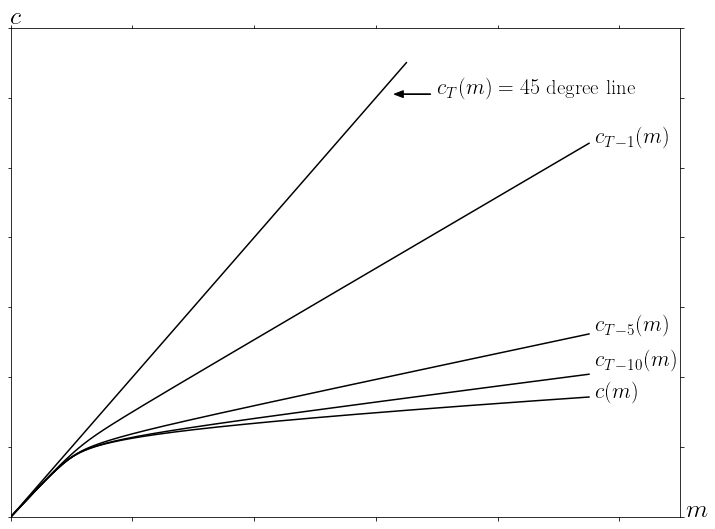

In [6]:
# Plot the different consumption rules for the different periods

m1 = np.linspace(0,9.5,1000) # Set the plot range of m
m2 = np.linspace(0,6.5,500)
c_m  = baseEx.cFunc[0](m1)   # c_m can be used to define the limiting inﬁnite-horizon consumption rule here
c_t1 = baseEx.cFunc[-2](m1) # c_t1 defines the second-to-last period consumption rule
c_t5 = baseEx.cFunc[-6](m1) # c_t5 defines the T-5 period consumption rule
c_t10 = baseEx.cFunc[-11](m1)  # c_t10 defines the T-10 period consumption rule
c_t0 = m2                            # c_t0 defines the last period consumption rule
plt.figure(figsize = (12,9))
plt.plot(m1,c_m,color="black")
plt.plot(m1,c_t1,color="black")
plt.plot(m1,c_t5,color="black")
plt.plot(m1,c_t10,color="black")
plt.plot(m2,c_t0,color="black")
plt.xlim(0,11)
plt.ylim(0,7)
plt.text(7,6,r'$c_{T}(m) = 45$ degree line',fontsize = 22,fontweight='bold')
plt.text(9.6,5.3,r'$c_{T-1}(m)$',fontsize = 22,fontweight='bold')
plt.text(9.6,2.6,r'$c_{T-5}(m)$',fontsize = 22,fontweight='bold')
plt.text(9.6,2.1,r'$c_{T-10}(m)$',fontsize = 22,fontweight='bold')
plt.text(9.6,1.7,r'$c(m)$',fontsize = 22,fontweight='bold')
plt.arrow(6.9,6.05,-0.6,0,head_width= 0.1,width=0.001,facecolor='black',length_includes_head='True')
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(0,7.05,"$c$",fontsize = 26)
plt.text(11.1,0,"$m$",fontsize = 26)
# Save the figures in several formats

make('cFuncsConverge') # Change to False if you want to run uninterrupted

### PROBLEM: Natural Borrowing Constraint Approaches Artificial Constraint

Show numerically the result that is proven analytically in [The-Liquidity-Constrained-Solution-as-a-Limit](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Liquidity-Constrained-Solution-as-a-Limit), by solving the model for successively smaller values of $\wp$.
   * You need only to solve for the second-to-last period of life to do this
      * `TwoPeriodModel = IndShockConsumerType(**base_params)`
      * `TwoPeriodModel.cycles = 2   # Make this type have a two period horizon (Set T = 2)`

   * You should show the consumption rules for different values of $\wp$ on the same graph
      * To make this easier, you will want to use the plotFuncs command:
         * `from HARK.utilities import plotFuncsDer, plotFuncs`

Create a cell or cells in the notebook below this cell and put your solution there; comment on the size of $\wp$ needed to make the two models visually indistinguishable

## Factors and Conditions

### [The Finite Human Wealth Condition](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Human-Wealth)

Human wealth for a perfect foresight consumer is defined as the present discounted value of future income:

\begin{eqnarray}
H_{t} & = & \mathbb{E}_{t}[P_{t} + \mathsf{R}^{-1} P_{t+1} + \mathsf{R}^{2} P_{t+2} ... ] \\ 
      & = & P_{t} \left(1 + (\Gamma/\mathsf{R}) + (\Gamma/\mathsf{R})^{2} ... \right)
\end{eqnarray}
which is an infinite number if $\Gamma/\mathsf{R} \geq 1$.  We say that the 'Finite Human Wealth Condition' (FHWC) holds if 
$0 \leq (\Gamma/\mathsf{R}) < 1$.

### [Absolute Patience and the AIC](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#AIC)

The paper defines the Absolute Patience Factor as being equal to the ratio $C_{t+1}/C_{t}$ for a perfect foresight consumer.  The Old English character <span style="font-size:larger;">"&#222;"</span> is used for this object in the paper, but <span style="font-size:larger;">"&#222;"</span> cannot currently be rendered conveniently in the mathematical displays in Jupyter notebooks, so we will substitute $\Phi$ here:

\begin{equation}
\Phi = (\mathsf{R} \beta)^{1/\rho} 
\end{equation}

If $\Phi = 1$, a perfect foresight consumer will spend exactly the amount that can be sustained perpetually (given their current and future resources).  If $\Phi < 1$ (the consumer is 'absolutely impatient'; or, 'the absolute impatience condition holds'), the consumer is consuming more than the sustainable amount, so consumption will fall, and if the consumer is 'absolutely patient' with $\Phi > 1$ consumption will grow over time.



### [Growth Patience and the GIC](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#GIC)

For a [perfect foresight consumer](http://econ.jhu.edu/people/ccarroll/public/lecturenotes/consumption/PerfForesightCRRA), whether the ratio of consumption to the permanent component of income $P$ is rising, constant, or falling depends on the relative growth rates of consumption and permanent income; that ratio is measured by the "Perfect Foresight Growth Patience Factor":

\begin{eqnarray}
\Phi_{\Gamma} & = & \Phi/\Gamma
\end{eqnarray}
and whether the ratio is falling or rising over time depends on whether $\Phi_{\Gamma}$ is below or above 1.

An analogous condition can be defined when there is uncertainty about permanent income.  Defining $\tilde{\Gamma} = (\mathbb{E}[\psi^{-1}])^{-1}\Gamma$, the 'Growth Impatience Condition' (GIC) is that 
\begin{eqnarray}
  \Phi/\tilde{\Gamma} & < & 1
\end{eqnarray}

### [The Finite Value of Autarky Condition (FVAC)](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Autarky-Value)

The paper [shows](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Autarky-Value) that a consumer who planned to spend his permanent income $\{ p_{t}, p_{t+1}, ...\} $ in every period would have value defined by

\begin{equation}
v_{t}^{\text{autarky}} = u(p_{t})\left(\frac{1}{1-\beta \Gamma^{1-\rho} \mathbb{E}[\psi^{1-\rho}]}\right)
\end{equation}

and defines the 'Finite Value of Autarky Condition' as the requirement that the denominator of this expression be a positive finite number:

\begin{equation}
\beta \Gamma^{1-\rho} \mathbb{E}[\psi^{1-\rho}] < 1
\end{equation}

### [The Weak Return Impatience Condition (WRIC)](http://www.econ2.jhu.edu/people/ccarroll/papers/BufferStockTheory/#WRIC)

The 'Return Impatience Condition' $\Phi/\mathsf{R} < 1$ has long been understood to be required for the perfect foresight model to have a nondegenerate solution (when $\rho=1$, this reduces to $\beta < R$).  If the RIC does not hold, the consumer is so patient that the optimal consumption function approaches zero as the horizon extends indefinitely.

When the probability of unemployment is $\wp$, the paper articulates an analogous (but weaker) condition:

\begin{eqnarray}
 \wp^{1/\rho} \Phi/\mathsf{R} & < & 1
\end{eqnarray}

# Key Results

## [Nondegenerate Solution Requires FVAC and WRIC](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Sufficient-Conditions-For-Nondegenerate-Solution)

A main result of the paper is that the conditions required for the model to have a nondegenerate solution ($0 < c(m) < \infty$ for feasible $m$) are that the Finite Value of Autarky (FVAC) and Weak Return Impatience Condition (WRAC) hold.

## [Natural Borrowing Constraint limits to Artificial Borrowing Constraint](http://www.econ2.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Liquidity-Constrained-Solution-as-a-Limit)

Defining $\chi(\wp)$ as the consumption function associated with any particular value of $\wp$, and defining $\hat{\chi}$ as the consumption function that would apply in the absence of the zero-income shocks but in the presence of an 'artificial' borrowing constraint requiring $a \geq 0$, a la Deaton (1991), the paper shows that 

\begin{eqnarray}
\lim_{\wp \downarrow 0}~\chi(\wp) & = & \hat{\chi}
\end{eqnarray}

That is, as $\wp$ approaches zero the problem with uncertainty becomes identical to the problem that instead has constraints.  (See [Precautionary Saving and Liquidity Constraints](http://econ.jhu.edu/people/ccarroll/papers/LiqConstr) for a full treatment of the relationship between precautionary saving and liquidity constraints).

## [$c(m)$ is Finite Even When Human Wealth Is Infinite](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#When-The-GIC-Fails)

In the perfect foresight model, if $\mathsf{R} < \Gamma$ the PDV of future labor income is infinite and so the limiting consumption function is $c(m) = \infty$ for all $m$.  Many models have no well-defined solution when human wealth is infinite.

The presence of uncertainty changes this: Even when "human wealth" is infinite, the limiting consumption function is finite for all values of $m$.  

This is because uncertainty imposes a "natural borrowing constraint" that deters the consumer from borrowing against their unbounded (but uncertain) future labor income.

A [table](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Sufficient-Conditions-For-Nondegenerate-Solution) puts this result in the context of implications of other conditions and restrictions.



## [If the GIC Holds, $\exists$ a finite 'target' $m$](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#onetarget)

Section [There Is Exactly One Target $m$ Ratio, Which Is Stable](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#onetarget) shows that, under parameter values for which the limiting consumption function exists, if the GIC holds then there will be a value $\check{m}$ such that:

\begin{eqnarray}
\mathbb{E}[m_{t+1}] & > & m_{t}~\text{if $m_{t} < \check{m}$} \\
\mathbb{E}[m_{t+1}] & < & m_{t}~\text{if $m_{t} > \check{m}$} \\
\mathbb{E}[m_{t+1}] & = & m_{t}~\text{if $m_{t} = \check{m}$}
\end{eqnarray} 

## [If the GIC Fails, Target Wealth is Infinite ](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-GIC)

[A figure](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#FVACnotGIC) depicts a solution when the **FVAC** (Finite Value of Autarky Condition) and **WRIC** hold (so that the model has a solution) but the **GIC** (Growth Impatience Condition) fails.  In this case the target wealth ratio is infinity.  

The parameter values in this specific example are:

| Param | Description | Code | Value |
| :---: | ---         | ---  | :---: |
| $\Gamma$ | Permanent Income Growth Factor | $\texttt{PermGroFac}$ | 1.00 |
| $\mathrm{\mathsf{R}}$ | Interest Factor | $\texttt{Rfree}$ | 1.06 |

The figure is reproduced below.

In [8]:
# Construct the "GIC fails" example.

GIC_fail_dictionary = dict(base_params)
GIC_fail_dictionary['Rfree']      = 1.04
GIC_fail_dictionary['PermGroFac'] = [1.00]

GICFailExample = IndShockConsumerType(
    cycles=0, # cycles=0 makes this an infinite horizon consumer
    **GIC_fail_dictionary)

The $\mathtt{IndShockConsumerType}$ tool automatically checks various parametric conditions, and will give a warning as well as the values of the factors if key conditions fail to be met. 

We can also directly check the conditions, asking for the maximum verbosity:

In [9]:
# The checkConditions method does what it sounds like it would
GICFailExample.checkConditions(verbose=True)

The value of the Perfect Foresight Growth Impatience Factor for the supplied parameter values satisfies the Perfect Foresight Growth Impatience Condition.  Therefore, the ratio of individual wealth to permanent income will fall indefinitely.

The given parameter values violate the Individual Growth Impatience Condition; the GIFInd is: 1.0086 
Therefore, a target ratio of individual market resources to individual permanent income does not exist.  (see http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#onetarget for more).

The value of the Aggregate Growth Impatience Factor for the supplied parameter values satisfies the Aggregate Growth Impatience Condition. Therefore, it is possible that a target level of the ratio of expected market resources to expected permanent income exists.

The Weak Return Impatience Factor value for the supplied parameter values satisfies the Weak Return Impatience Condition (see http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#WRIC for

### The Sustainable Level of Consumption

Next we define the function $\mathrm{\mathbb{E}}_{t}[\Delta m_{t+1}]$ that shows the ‘sustainable’ level of spending at which $m$ is expected to remain unchanged.

In [10]:
# Calculate "Sustainable" consumption that leaves expected m unchanged
# In the perfect foresight case, this is just permanent income plus interest income
# A small adjustment is required to take account of the consequences of uncertainty
# See "Growth Patience and the GIC" above
InvEpShkInvAct = np.dot(GICFailExample.PermShkDstn[0][0], GICFailExample.PermShkDstn[0][1]**(-1))
InvInvEpShkInvAct = (InvEpShkInvAct) ** (-1)                      # $E[\psi^{-1}]$
PermGroFacAct = GICFailExample.PermGroFac[0] * InvInvEpShkInvAct # $(E[\psi^{-1}])^{-1}$
ERnrm   = GICFailExample.Rfree / PermGroFacAct # Interest factor normalized by uncertainty-adjusted growth
Ernrm   = ERnrm - 1                            # Interest rate is interest factor - 1 
mSSfunc = lambda m : 1 + (m-1)*(Ernrm/ERnrm)   # "sustainable" consumption: consume your (discounted) interest income

### PROBLEM: Target Wealth and Impatience

Given the above results proving that there is a finite target $m$ if the Growth Impatience Factor is less than one ('the GIC holds'), but that $m \uparrow \infty$ if the GIC fails, it will not surprise you to learn that the target approaches infinity as the GIF approaches 1.

This problem asks you to verify that proposition by calculating and plotting values of the GIF for a sequence of $\beta$ values that cause the GIF to be closer and closer to 1.

In doing this, it will be useful to know that the GIF is calculated in the $\texttt{checkConditions}$ method.  (Look in $\texttt{ConsIndShockModel.py}$).


The given parameter values violate the Individual Growth Impatience Condition; the GIFInd is: 1.0086 

Saving figure FVACnotGIC in Figures


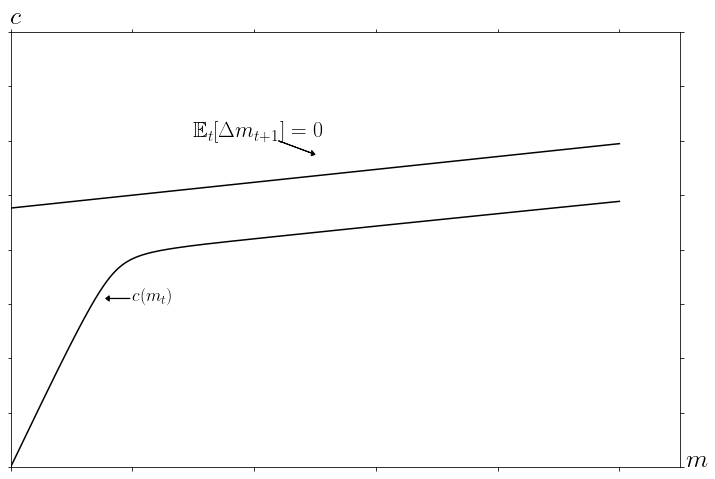

In [12]:
# Plot GICFailExample consumption function against the sustainable level of consumption

GICFailExample.solve() # Above, we set up the problem but did not solve it 
GICFailExample.unpackcFunc()  # Make the consumption function easily accessible for plotting
m = np.linspace(0,5,1000)
c_m = GICFailExample.cFunc[0](m)
E_m = mSSfunc(m)
plt.figure(figsize = (12,8))
plt.plot(m,c_m,color="black")
plt.plot(m,E_m,color="black")
plt.xlim(0,5.5)
plt.ylim(0,1.6)
plt.text(0,1.63,"$c$",fontsize = 26)
plt.text(5.55,0,"$m$",fontsize = 26)
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(1,0.6,"$c(m_{t})$",fontsize = 18)
if latexExists:
    plt.text(1.5,1.2,"$\mathbb{E}_{t}[\Delta m_{t+1}] = 0$",fontsize = 22)
else:
    plt.text(1.5,1.2,"$\mathsf{E}_{t}[\Delta m_{t+1}] = 0$",fontsize = 22)

plt.arrow(0.98,0.62,-0.2,0,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(2.2,1.2,0.3,-0.05,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')

make('FVACnotGIC')

In [13]:
# Conditions can also be checked without solving the model
GICFailExample.checkConditions(verbose=True)  # Make the consumption function easily accessible for plotting

The value of the Perfect Foresight Growth Impatience Factor for the supplied parameter values satisfies the Perfect Foresight Growth Impatience Condition.  Therefore, the ratio of individual wealth to permanent income will fall indefinitely.

The given parameter values violate the Individual Growth Impatience Condition; the GIFInd is: 1.0086 
Therefore, a target ratio of individual market resources to individual permanent income does not exist.  (see http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#onetarget for more).

The value of the Aggregate Growth Impatience Factor for the supplied parameter values satisfies the Aggregate Growth Impatience Condition. Therefore, it is possible that a target level of the ratio of expected market resources to expected permanent income exists.

The Weak Return Impatience Factor value for the supplied parameter values satisfies the Weak Return Impatience Condition (see http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#WRIC for

As a foundation for the remaining figures, we define another instance of the class $\texttt{IndShockConsumerType}$, which has the same parameter values as the instance $\texttt{baseEx}$ defined previously but is solved to convergence (our definition of an infinite horizon agent type) instead of only 100 periods


In [14]:
# cycles=0 tells the solver to find the infinite horizon solution
baseEx_inf = IndShockConsumerType(cycles=0,**base_params)

baseEx_inf.solve()
baseEx_inf.unpackcFunc()

### [Target $m$, Expected Consumption Growth, and Permanent Income Growth](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#AnalysisoftheConvergedConsumptionFunction)

The next figure is shown in  [Analysis of the Converged Consumption Function](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#cGroTargetFig), which shows the expected consumption growth factor $\mathrm{\mathbb{E}}_{t}[c_{t+1}/c_{t}]$ for a consumer behaving according to the converged consumption rule.


In [15]:
# Define a function to calculate expected consumption 
def exp_consumption(a):
    '''
    Taking end-of-period assets a as input, return expectation of next period's consumption
    Inputs:
       a: end-of-period assets
    Returns:
       expconsump: next period's expected consumption
    '''
    GrowFac_tp1 = baseEx_inf.PermGroFac[0]* baseEx_inf.PermShkDstn[0][1]
    Rnrm_tp1 = baseEx_inf.Rfree / GrowFac_tp1
    # end-of-period assets plus normalized returns
    b_tp1 = Rnrm_tp1*a
    # expand dims of b_tp1 and use broadcasted sum of a column and a row vector
    # to obtain a matrix of possible beginning-of-period assets next period
    # This is much much faster than looping 
    m_tp1 = np.expand_dims(b_tp1, axis=1) + baseEx_inf.TranShkDstn[0][1]
    part_expconsumption = GrowFac_tp1*baseEx_inf.cFunc[0](m_tp1).T
    # finish expectation over perm shocks by right multiplying with weights
    part_expconsumption = np.dot(part_expconsumption, baseEx_inf.PermShkDstn[0][0])
    # finish expectation over trans shocks by right multiplying with prob weights
    expconsumption = np.dot(part_expconsumption, baseEx_inf.TranShkDstn[0][0])
    # return expected consumption
    return expconsumption

In [16]:
# Calculate the expected consumption growth factor
m1 = np.linspace(1,baseEx_inf.solution[0].mNrmSS,50) # m1 defines the plot range on the left of target m value (e.g. m <= target m)
c_m1 = baseEx_inf.cFunc[0](m1)
a1 = m1-c_m1
exp_consumption_l1 = [exp_consumption(i) for i in a1]

# growth1 defines the plotted values consumption growth factor when m is less than target m
growth1 = np.array(exp_consumption_l1)/c_m1

# m2 defines the plot range on the right of target m value (e.g. m >= target m)
m2 = np.linspace(baseEx_inf.solution[0].mNrmSS,1.9,50)

c_m2 = baseEx_inf.cFunc[0](m2)
a2 = m2-c_m2
exp_consumption_l2 = [exp_consumption(i) for i in a2]

# growth 2 constructs values to plot of expected consumption growth factor when m is bigger than target m
growth2 = np.array(exp_consumption_l2)/c_m2

In [17]:
# Define a function to construct the arrows on the consumption growth rate function
def arrowplot(axes, x, y, narrs=15, dspace=0.5, direc='neg',
              hl=0.01, hw=3, c='black'):
    '''
    The function is used to plot arrows given the data x and y.

    Input:
        narrs  :  Number of arrows that will be drawn along the curve

        dspace :  Shift the position of the arrows along the curve.
                  Should be between 0. and 1.

        direc  :  can be 'pos' or 'neg' to select direction of the arrows

        hl     :  length of the arrow head

        hw     :  width of the arrow head

        c      :  color of the edge and face of the arrow head
    '''

    # r is the distance spanned between pairs of points
    r = np.sqrt(np.diff(x)**2+np.diff(y)**2)
    r = np.insert(r, 0, 0.0)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = np.cumsum(r)

    # based on narrs set the arrow spacing
    aspace = r.sum() / narrs

    if direc is 'neg':
        dspace = -1.*abs(dspace)
    else:
        dspace = abs(dspace)

    arrowData = [] # will hold tuples of x,y,theta for each arrow
    arrowPos = aspace*(dspace) # current point on walk along data
                                 # could set arrowPos to 0 if you want
                                 # an arrow at the beginning of the curve

    ndrawn = 0
    rcount = 1
    while arrowPos < r.sum() and ndrawn < narrs:
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        da = arrowPos-rtot[rcount]
        theta = np.arctan2((x2-x1),(y2-y1))
        ax = np.sin(theta)*da+x1
        ay = np.cos(theta)*da+y1
        arrowData.append((ax,ay,theta))
        ndrawn += 1
        arrowPos+=aspace
        while arrowPos > rtot[rcount+1]:
            rcount+=1
            if arrowPos > rtot[-1]:
                break

    for ax,ay,theta in arrowData:
        # use aspace as a guide for size and length of things
        # scaling factors were chosen by experimenting a bit

        dx0 = np.sin(theta)*hl/2.0 + ax
        dy0 = np.cos(theta)*hl/2.0 + ay
        dx1 = -1.*np.sin(theta)*hl/2.0 + ax
        dy1 = -1.*np.cos(theta)*hl/2.0 + ay

        if direc is 'neg' :
            ax0 = dx0
            ay0 = dy0
            ax1 = dx1
            ay1 = dy1
        else:
            ax0 = dx1
            ay0 = dy1
            ax1 = dx0
            ay1 = dy0

        axes.annotate('', xy=(ax0, ay0), xycoords='data',
                xytext=(ax1, ay1), textcoords='data',
                arrowprops=dict( headwidth=hw, frac=1., ec=c, fc=c))

Saving figure cGroTargetFig in Figures


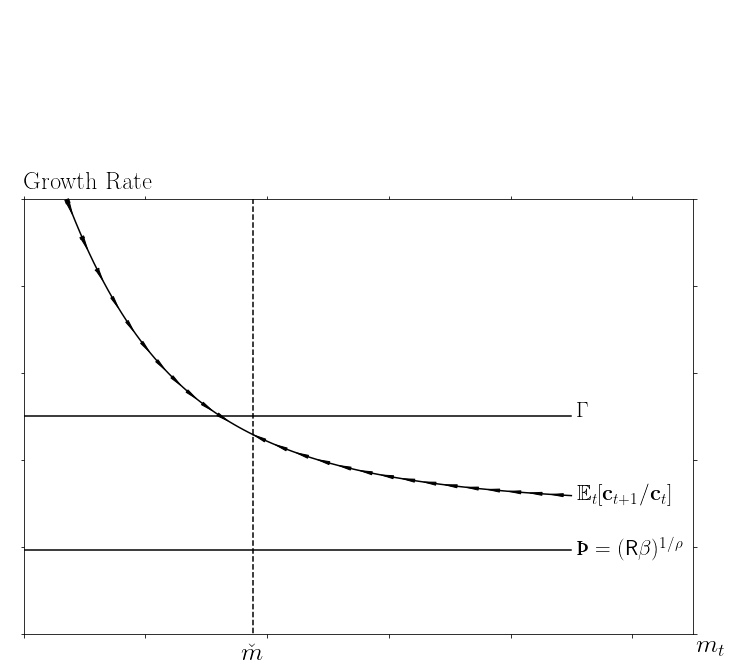

In [18]:
# Plot consumption growth as a function of market resources
# Calculate Absolute Patience Factor Phi = lower bound of consumption growth factor
AbsPatientFac = (baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
# Plot the Absolute Patience Factor line
ax.plot([0,1.9],[AbsPatientFac,AbsPatientFac],color="black")

# Plot the Permanent Income Growth Factor line
ax.plot([0,1.9],[baseEx_inf.PermGroFac[0],baseEx_inf.PermGroFac[0]],color="black")

# Plot the expected consumption growth factor on the left side of target m
ax.plot(m1,growth1,color="black")

# Plot the expected consumption growth factor on the right side of target m
ax.plot(m2,growth2,color="black")

# Plot the arrows
arrowplot(ax, m1,growth1)
arrowplot(ax, m2,growth2, direc='pos')

# Plot the target m
ax.plot([baseEx_inf.solution[0].mNrmSS,baseEx_inf.solution[0].mNrmSS],[0,1.4],color="black",linestyle="--")
ax.set_xlim(1,2.10)
ax.set_ylim(0.98,1.08)
ax.text(1,1.082,"Growth Rate",fontsize = 26,fontweight='bold')
ax.text(2.105,0.975,"$m_{t}$",fontsize = 26,fontweight='bold')
if latexExists:
    ax.text(1.91,1.01,"$\mathbb{E}_{t}[\mathbf{c}_{t+1}/\mathbf{c}_{t}]$",fontsize = 22,fontweight='bold')
else:
    ax.text(1.91,1.01,"$\mathsf{E}_{t}[c_{t+1}/c_{t}]$",fontsize = 22,fontweight='bold')
ax.text(baseEx_inf.solution[0].mNrmSS-0.02,0.974, r'$\check{m}$', fontsize = 26,fontweight='bold')
ax.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
if latexExists:
    ax.text(1.91,0.998,r'$\pmb{\text{\TH}} = (\mathrm{\mathsf{R}}\beta)^{1/\rho}$',fontsize = 22,fontweight='bold')
else:
    ax.text(1.91,0.998,r'$\Phi = (\mathrm{\mathsf{R}}\beta)^{1/\rho}$',fontsize = 22,fontweight='bold')

ax.text(1.91,1.03, r'$\Gamma$',fontsize = 22,fontweight='bold')
make('cGroTargetFig')

### [Consumption Function Bounds](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#AnalysisOfTheConvergedConsumptionFunction)
[The next figure](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#cFuncBounds)
illustrates theoretical bounds for the consumption function.

We define two useful variables: lower bound of $\kappa$ (marginal propensity to consume) and limit of $h$ (Human wealth), along with some functions such as the limiting perfect foresight consumption function $\bar{c}(m)$, the upper bound function $\bar{\bar c}(m)$, and the lower bound function \underline{_c_}$(m)$.

In [19]:
# Define k_lower, h_inf and perfect foresight consumption function, upper bound of consumption function and lower
# bound of consumption function.
k_lower = 1.0-(baseEx_inf.Rfree**(-1.0))*(baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)
h_inf = (1.0/(1.0-baseEx_inf.PermGroFac[0]/baseEx_inf.Rfree))
conFunc_PF = lambda m: (h_inf -1)* k_lower + k_lower*m
conFunc_upper = lambda m: (1 - baseEx_inf.UnempPrb ** (1.0/baseEx_inf.CRRA)*(baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)/baseEx_inf.Rfree)*m
conFunc_lower = lambda m: (1 -(baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)/baseEx_inf.Rfree) * m
intersect_m = ((h_inf-1)* k_lower)/((1 - baseEx_inf.UnempPrb
            **(1.0/baseEx_inf.CRRA)*(baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)/baseEx_inf.Rfree)-k_lower)

Saving figure cFuncBounds in Figures


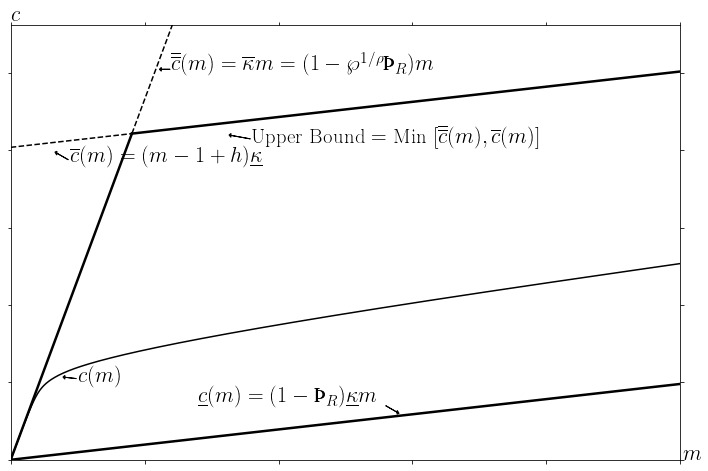

In [20]:
# Plot the consumption function and its bounds

cMaxLabel=r'$\overline{c}(m) = (m-1+h)\underline{\kappa}$'
cMinLabel=r'$\underline{c}(m)= (1-\pmb{\text{\TH}}_{R})\underline{\kappa}m$'
if not latexExists:
    cMaxLabel=r'$\overline{c}(m) = (m-1+h)κ̲' # Use unicode kludge
    cMinLabel=r'c̲$(m)= (1-\Phi_{R})m = κ̲ m$' 
    
x1 = np.linspace(0,25,1000)
x3 = np.linspace(0,intersect_m,300)
x4 = np.linspace(intersect_m,25,700)
cfunc_m = baseEx_inf.cFunc[0](x1)
cfunc_PF_1 = conFunc_PF(x3)
cfunc_PF_2 = conFunc_PF(x4)
cfunc_upper_1 = conFunc_upper(x3)
cfunc_upper_2 = conFunc_upper(x4)
cfunc_lower = conFunc_lower(x1)
plt.figure(figsize = (12,8))
plt.plot(x1,cfunc_m, color="black")
plt.plot(x1,cfunc_lower, color="black",linewidth=2.5)
plt.plot(x3,cfunc_upper_1, color="black",linewidth=2.5)
plt.plot(x4,cfunc_PF_2 , color="black",linewidth=2.5)
plt.plot(x4,cfunc_upper_2 , color="black",linestyle="--")
plt.plot(x3,cfunc_PF_1 , color="black",linestyle="--")
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.xlim(0,25)
plt.ylim(0,1.12*conFunc_PF(25))
plt.text(0,1.12*conFunc_PF(25)+0.05,"$c$",fontsize = 22)
plt.text(25+0.1,0,"$m$",fontsize = 22)
plt.text(2.5,1,r'$c(m)$',fontsize = 22,fontweight='bold')
if latexExists:
    plt.text(6,5,r'$\overline{\overline{c}}(m)= \overline{\kappa}m = (1-\wp^{1/\rho}\pmb{\text{\TH}}_{R})m$',fontsize = 22,fontweight='bold')
else:
    plt.text(6,5,r'$\overline{\overline{c}}(m)= \overline{\kappa}m = (1-\wp^{1/\rho}\Phi_{R})m$',fontsize = 22,fontweight='bold')
plt.text(2.2,3.8, cMaxLabel,fontsize = 22,fontweight='bold')
plt.text(9,4.1,r'Upper Bound $ = $ Min $[\overline{\overline{c}}(m),\overline{c}(m)]$',fontsize = 22,fontweight='bold')
plt.text(7,0.7,cMinLabel,fontsize = 22,fontweight='bold')
plt.arrow(2.45,1.05,-0.5,0.02,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(2.15,3.88,-0.5,0.1,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(8.95,4.15,-0.8,0.05,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(5.95,5.05,-0.4,0,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(14,0.70,0.5,-0.1,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')

make('cFuncBounds')

### [The Consumption Function and Target $m$](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#cFuncBounds)

This figure shows the $\mathrm{\mathbb{E}}_{t}[\Delta m_{t+1}]$ and consumption function $c(m_{t})$, along with the intersection of these two functions, which defines the target value of $m$

Saving figure cRatTargetFig in Figures


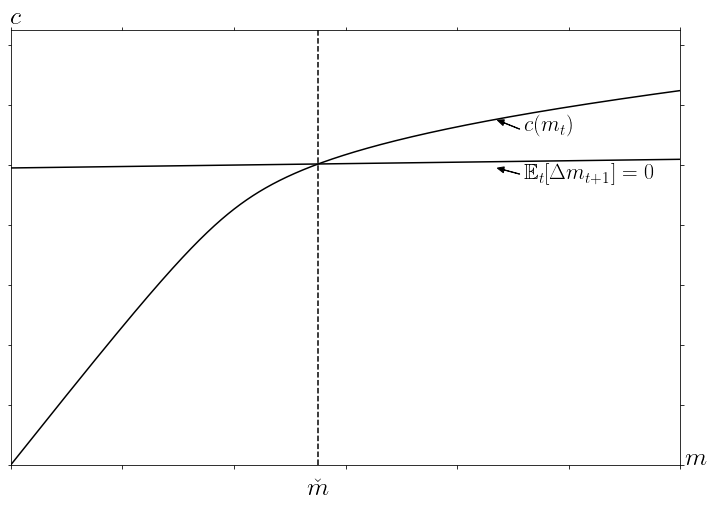

In [21]:
# This just plots objects that have already been constructed

m1 = np.linspace(0,4,1000)
cfunc_m = baseEx_inf.cFunc[0](m1)
mSSfunc = lambda m:(baseEx_inf.PermGroFac[0]/baseEx_inf.Rfree)+(1.0-baseEx_inf.PermGroFac[0]/baseEx_inf.Rfree)*m
mss = mSSfunc(m1)
plt.figure(figsize = (12,8))
plt.plot(m1,cfunc_m, color="black")
plt.plot(m1,mss, color="black")
plt.xlim(0,3)
plt.ylim(0,1.45)
plt.plot([baseEx_inf.solution[0].mNrmSS, baseEx_inf.solution[0].mNrmSS],[0,2.5],color="black",linestyle="--")
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(0,1.47,r"$c$",fontsize = 26)
plt.text(3.02,0,r"$m$",fontsize = 26)
if latexExists:
    plt.text(2.3,0.94,r'$\mathbb{E}_{t}[\Delta m_{t+1}] = 0$',fontsize = 22,fontweight='bold')
else:
    plt.text(2.3,0.94,r'$\mathsf{E}_{t}[\Delta m_{t+1}] = 0$',fontsize = 22,fontweight='bold')
plt.text(2.3,1.1,r"$c(m_{t})$",fontsize = 22,fontweight='bold')
plt.text(baseEx_inf.solution[0].mNrmSS-0.05,-0.1, r"$\check{m}$",fontsize = 26)
plt.arrow(2.28,1.12,-0.1,0.03,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(2.28,0.97,-0.1,0.02,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')

make('cRatTargetFig')

### [Upper and Lower Limits of the Marginal Propensity to Consume](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#MPCLimits)

The paper shows that as $m_{t}~\uparrow~\infty$ the consumption function in the presence of risk gets arbitrarily close to the perfect foresight consumption function.  Defining \underline{κ}
as the perfect foresight model's MPC, this implies that $\lim_{m_{t}~\uparrow~\infty} c^{\prime}(m) = $ \underline{κ}
.

The paper also derives an analytical limit $\bar{\kappa}$ for the MPC as $m$ approaches 0., its bounding value.  Strict concavity of the consumption function implies that the consumption function will be everywhere below a function $\bar{\kappa}m$, and strictly declining everywhere.  The last figure plots the MPC between these two limits.

Saving figure MPCLimits in Figures


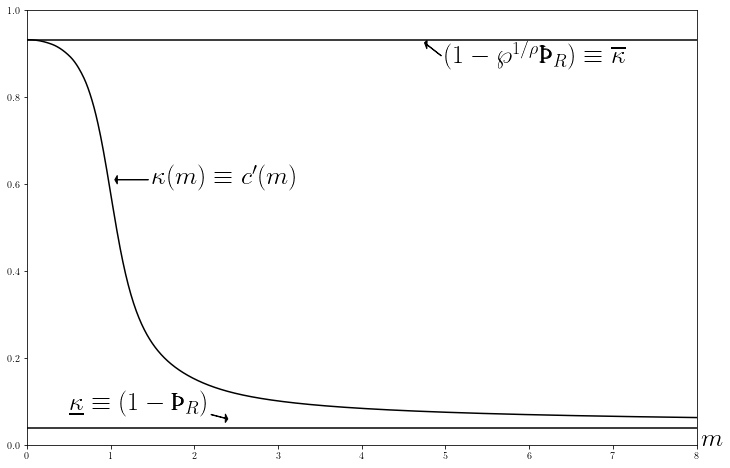

In [22]:
# The last figure shows the upper and lower limits of the MPC
plt.figure(figsize = (12,8))
# Set the plot range of m
m = np.linspace(0.001,8,1000)

# Use the HARK method derivative to get the derivative of cFunc, and the values are just the MPC
MPC = baseEx_inf.cFunc[0].derivative(m)

# Define the upper bound of MPC
MPCUpper = (1 - baseEx_inf.UnempPrb ** (1.0/baseEx_inf.CRRA)*(baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)/baseEx_inf.Rfree)

# Define the lower bound of MPC
MPCLower = k_lower

kappaDef=r'$\underline{\kappa}\equiv(1-\pmb{\text{\TH}}_{R})$'
if not latexExists:
    kappaDef=r'κ̲$\equiv(1-\Phi_{R})$'

plt.plot(m,MPC,color = 'black')
plt.plot([0,8],[MPCUpper,MPCUpper],color = 'black')
plt.plot([0,8],[MPCLower,MPCLower],color = 'black')
plt.xlim(0,8)
plt.ylim(0,1)
plt.text(1.5,0.6,r'$\kappa(m) \equiv c^{\prime}(m)$',fontsize = 26,fontweight='bold')
if latexExists:
    plt.text(5,0.87,r'$(1-\wp^{1/\rho}\pmb{\text{\TH}}_{R})\equiv \overline{\kappa}$',fontsize = 26,fontweight='bold') # Use Thorn character
else:
    plt.text(5,0.87,r'$(1-\wp^{1/\rho}\Phi_{R})\equiv \overline{\kappa}$',fontsize = 26,fontweight='bold') # Use Phi instead of Thorn (alas)
    
plt.text(0.5,0.07,kappaDef,fontsize = 26,fontweight='bold')
plt.text(8.05,0,"$m$",fontsize = 26)
plt.arrow(1.45,0.61,-0.4,0,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(2.2,0.07,0.2,-0.01,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(4.95,0.895,-0.2,0.03,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')

make('MPCLimits')

# Summary

[Two tables in the paper](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Factors-Defined-And-Compared) summarize the various definitions, and then articulate conditions required for the problem to have a nondegenerate solution.  Among the nondegenerate cases, the most interesting result is that if the Growth Impatience Condition holds there will be a target level of wealth.